# Procesos Markovianos para el Aprendizaje Automático
# TP.2 - Bandits

### Alumno: Leandro Carreira - 669/18

In [175]:
# Check for Python's version
import sys
print(sys.version)

3.7.2 (default, Dec 29 2018, 06:19:36) 
[GCC 7.3.0]


In [108]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

In [109]:
class BernoulliBanditEnv(object): 
    # Clase que define el environment donde el reward es 0 o 1 dependiendo de una probabilidad p.

    def __init__(self, num_arms=10, p=None):
        self.num_arms = num_arms
        self.actions  = np.arange(num_arms)     # define set of actions

        if len(p)==1:
            self.p = np.random.beta(0.5, 0.5, size=num_arms)
        elif len(p) == num_arms:
            self.p = p
        else:
            raise Exception('Number of probabilities ({}) does not correspond to number of arms ({}).'.format(len(q), num_arms))
        self.best_action = np.argmax(self.p)   # La mejor accion dado el enviroenmenteneas

    def reward(self, action):
        return np.random.binomial(1, p=self.p[action])


In [166]:
class Agent(object):
    # Clase que define al agente. Cada agente cuenta con una regla de decisión y una regla de aprendizaje.
    def __init__(self, learning_rule, decision_rule, param=None):
        self.decision_rule = decision_rule
        self.learning_rule = learning_rule

        if decision_rule == "epsilon-greedy":
            self.epsilon = param["epsilon"]
        
        if decision_rule == "UCB":
            self.UCB_param = param["UCB_param"]
        
        if decision_rule == "gradient":
            self.lr = param["lr"]
    
    def environment(self, env, init_q):
        # inicializa el environment
        self.env = env                                  
        self.k = env.num_arms                           
        self.actions = np.arange(self.k)                
        self.act_count = np.zeros(self.k)               
        self.iteration = 0     
        if self.learning_rule == "BayesianBetaPrior":
            self.alpha = np.random.uniform(size=self.k)
            self.beta  = np.random.uniform(size=self.k)
        if len(init_q) == self.k:
            self.q_estimate = init_q
        else:
            raise Exception('Number of initial values ({}) does not correspond to number of arms ({}).'.format(len(init_q), self.k))

    def learn(self, a, r):
        # Guardo last_reward para el gradient bandits
        if self.decision_rule == "gradient":
            self.last_action = a
            self.last_reward = r
        
        # Dada una acción y una recompenza, actualiza la value function.
        if self.learning_rule == "averaging":
            #print(a, self.act_count, 1/self.act_count[a] * (r - self.q_estimate[a]))
            self.q_estimate[a] += 1/self.act_count[a] * (r - self.q_estimate[a])
            
        if self.learning_rule == "BayesianBetaPrior":
            self.alpha[a] += r
            self.beta[a]  += 1 - r 
            
    def act(self):
        # realiza una acción.
        self.iteration += 1 
        
        if self.decision_rule == "greedy":
            selected_action = greedyAction(self.q_estimate)
            pass
        if self.decision_rule == "epsilon-greedy":
            selected_action = epsilonGreedyAction(self.q_estimate, self.epsilon)
            pass
        if self.decision_rule == "UCB":
            selected_action = upperConfidenceBoundAction(self.q_estimate, self.UCB_param, self.iteration, self.act_count)
            pass
        if self.decision_rule == "gradient":
            if self.iteration == 1:
                # First action decision, without having rewards, so
                # equal preferences for each action
                self.pref = np.empty(self.k)
                self.pref.fill(0)
                # Declaring variables we are gonna need 
                self.last_reward = 0
                self.last_action = 0
            selected_action = gradientBanditAction(self.q_estimate, self.pref, self.lr,
                                                   self.last_action, self.last_reward,
                                                   self.iteration, self.k)
            pass
        if self.decision_rule == "Thompson":
            # COMPLETAR
            pass
        self.act_count[selected_action] += 1
        return selected_action

In [167]:
def greedyAction(q_estimate):
    # Choose greedly one of the best actions
    return randomArgmax(q_estimate)

def epsilonGreedyAction(q_estimate, eps):
    # Greedy action with prob p=1-eps, random with prob eps=1-p
    if np.random.choice([True, False], p=[1-eps, eps]):
        # Greedy action
        return greedyAction(q_estimate)
    else:
        # Random action
        return np.random.choice(np.arange(len(q_estimate)))

def upperConfidenceBoundAction(q_estimate, c, iteration, act_count):
    # De Sutton:
    # "if action a was never chosen > a is a maximizing action"
    # NO quiero que las acciones jamas elegidas 'me pisen' acciones con
    # pesos fuertes por tener peso infinito al dividir por cero.
    uncertainty = np.sqrt(np.log(iteration)/np.maximum(1, act_count))
    # Con 'maximizing action' de Sutton, elijo su valor a partir del maximo de las
    # acciones ya elegidas.
    # ie: Las acciones no elegidas tienen EL MISMO valor que LA MEJOR accion elegida hasta el momento,
    #     de esa forma evito que solo elija acciones NO tomadas hasta que las tome todas.
    # 1. q_estimate + uncertainty para acciones ya elegidas (ignoro las NO elegidas)
    part_candidates = q_estimate + c*np.where(act_count>0, uncertainty, 0)
    # 2. le doy el max puntaje (de q_estimate) a las acciones NO elegidas
    candidates = np.where(act_count>0, part_candidates, np.amax(part_candidates))
    return randomArgmax(candidates)

### Gradient Bandits
Gradient bandits actualiza la preferencia de cada accion deacuerdo a 
la diferencia entre el reward obtenido y el promedio

<img src="img/gradient-bandits.png" width="500" align="left" />

In [ ]:
def gradientBanditAction(q_estimate, pref, lr, last_action, last_reward, iteration, arms):
    # H (self.pref) funcion de preferencia que actualiza cuando compara
    # el reward R que obtuve con mi reward promedio estimado R^
    # Debo actualizar dos cosas:
    #    la preferencia de la accion que tome (aumenta o disminuye)
    #    la preferencia de las otras acciones (disminuyen o aumentan)
    actions = np.arange(arms)
    # Observacion importante:
    # Usar q_estimate en esta linea de codigo EVITA la convergencia del algoritmo
    # r_diff parece no corresponder a un update en favor de un mejor update de pref (H)
    # Todavía no encuentro la falla, aunque he observado:
    #    0.- usando -q_estimate[a] como en Sutton NO converge
    #r_diff = last_reward - q_estimate[last_action]
    #
    # Pero CONVERGE:
    #    1.- usando +q_estimate
    #r_diff = last_reward + q_estimate[last_action]
    #    2.- usando q_estimate * 0 converge (r_diff = last_reward)
    #r_diff = last_reward - q_estimate[last_action]*0
    #
    #    3.- usando q_estimate[a]/c converge (para una constante c > 1)
    #        Distintos valores de c modifican la velocidad de convergencia
    #r_diff = last_reward - q_estimate[last_action]/2.0
    #
    #    4.- en el caso de 2 arms, usando q_estimate[a DEL OTRO arm] converge (sí, QUÉ!?)
    #r_diff = last_reward - q_estimate[(last_action+1)%2]
    #
    #    5.- usando q_estimate[random index] converge 
    #r_diff = last_reward - q_estimate[np.random.choice(actions)]
    #
    # Desde el día del labo (hace 2 semanas) estoy revisando este algoritmo sin entender 
    # el por qué no funciona como deberia.
    #
    # Me gustaria creer que en algun lado q_estimate toma la referencia de otro array 
    # y es modificado de manera erronea, pero todo comienza con q_estimate siendo
    # igualado a init_q, llamado desde agent.environment(env, np.zeros(narms)) con un init_q array de ceros
    # que ni siquiera tiene una referencia explicita y es inicializado en 0 en cada repeticion,
    # pisando valores de episodios anteriores ya terminados (lo cual es correcto para promediar experimentos).
    # 
    # Por el momento dejo +q_est que parece converger con menor ruido que las alternativas con alambre,
    # sobre todo en ultimos plots comparando varios agentes/learning rates.
    # TODO: finalmente, ver por qué.
    r_diff = last_reward + q_estimate[last_action]
    indicactor = np.where(actions==last_action, np.ones(arms), 0)
    pi = softmax_vect(pref)
    pref += lr * r_diff * (indicactor-pi)
    pi = softmax_vect(pref)
    selected_action = np.random.choice(actions, p=pi)
    return selected_action

In [168]:
def randomArgmax(v):
    """Like np.argmax(), but if there are several "best" actions,
       chooses and returns one randomly"""
    arguments = np.argwhere(v == np.amax(v)).ravel()
    arg = np.random.choice(arguments)
    return arg

def softmax_vect(v):
    """Returns a vector with all softmax values"""
    exp_vect = np.exp(v)
    return exp_vect/np.sum(exp_vect)

In [114]:
def simulateBandits(agents, narms, initp=None, initq=None, repetitions=100, N=1000):
    # Función que realiza las simulaciones de los agentes.
    # Se define el número de repeticiones que seran promediadas y el número de pasos N.
    # agents es una lista de agentes.
    rewards = np.zeros((len(agents), repetitions, N))
    bestarm = np.zeros((len(agents), repetitions, N))
    for i, agent in enumerate(agents):
        for j in np.arange(repetitions):
            environment = BernoulliBanditEnv(num_arms=narms, p=initp)
            agent.environment(environment, initq if not(np.array_equal(initq, None)) else np.zeros(narms))
            for n in np.arange(N):
                a = agent.act()
                r = environment.reward(a)
                agent.learn(a, r)
                rewards[i, j, n] = r
                bestarm[i, j, n] = 1 if a == environment.best_action else 0
    
    return np.squeeze(np.mean(rewards, axis=1)), np.squeeze(np.mean(bestarm, axis=1))

In [149]:
def plot_results(agents, actions, rewards, repetitions=100, N=1000):
    # Simulates and plot data
    # Generating data
    total_data = np.asarray(simulateBandits(agents, narms=actions, initp=rewards, initq=None,
                                            repetitions=repetitions, N=N))
    # data shape: (rewards, agents, time step)
    if len(agents)==1:
        # reshaping as several actor data, so it matches dimensions
        total_data = total_data.reshape(2,1,N)
    # Defining plots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))
    # Subplot 1: Rewards over time
    ax1.set_title("Rewards over time")
    ax1.set_xlabel("time step")
    ax1.set_ylabel("reward")
    ax1.grid()
    # Subplot 2: Agent's rate of choosing best arm
    ax2.set_title("Rate of choosing best arm")
    ax2.set_xlabel("time step")
    ax2.set_ylabel("rate")
    ax2.grid()
    # Subplot 3: Cumulative reward
    ax3.set_title("Cumulative reward")
    ax3.set_xlabel("time step")
    ax3.set_ylabel("cumulative reward")
    ax3.grid()
    time_steps = np.arange(1, N+1)
    # Doing fancy stuff with colors
    colors=iter(cm.Set1(np.linspace(0,1,len(agents))))
    # looping over individual agent data
    for a in range(total_data.shape[-2]):
        # data from each agent
        data = total_data[:,a,:]
        # Get agent parameters for labels
        de_rule = agents[a].decision_rule
        de_param = ""
        if de_rule == "epsilon-greedy":
            de_param = agents[a].epsilon
        if de_rule == "UCB":
            de_param = agents[a].UCB_param
        if de_rule == "gradient":
            de_param = agents[a].lr
        # Subplot 1: Rewards over time
        color = next(colors)
        ax1.plot(time_steps, data[0,:], marker=".", linestyle='-', linewidth=0.2,
                 color=color, label="agent-"+str(a+1)+"-"+de_rule+" "+str(de_param))
        ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        # Subplot 2: Agent's rate of choosing best arm
        ax2.plot(time_steps, data[1,:], marker=".", linestyle='-', linewidth=0.2,
                 color=color, label="agent-"+str(a+1)+"-"+de_rule+" "+str(de_param))
        ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        # Subplot 3: Cumulative reward
        ax3.plot(time_steps, np.cumsum(data[1,:]), marker=".", markersize=1, linestyle='-', linewidth=0.5,
                 color=color,
                 label="agent-"+str(a+1)+"-"+de_rule+" "+str(de_param))
        # black straight line from first to last value to see curvatures
        ax3.plot([time_steps[0], time_steps[-1]],
                 [np.cumsum(data[1,:])[0], np.cumsum(data[1,:])[-1]],
                 'ko-',  markersize=4, linewidth=0.5)
        ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

# Ejercicios:

[1.](#TP.2---Bandits) Completar pertinentemente el código donde diga "COMPLETAR".

[2.](#2.-Bandits-de-2-brazos) Realizar simulaciones con un bandit de 2 brazos (P = [0.4, 0.8]) para cada una de las reglas de decisión y graficar la recompensa promedio, la recompensa acumulada y el porcentaje de veces que fue elegido el mejor brazo en función de los pasos. Interprete los resultados.

[3.](#3.-Bandits-de-10-brazos) Realizar simulaciones con un bandit de 10 brazos (P = [0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]) para cada una de las reglas de decisión y graficar la recompensa promedio, la recompensa acumulada y el porcentaje de veces que fue elegido el mejor brazo en función de los pasos. Interprete los resultados.

[4.](#4.-Estudio-de-Epsilon-Greedy) Estudie la dependencia del hiperparametro epsilon en la regla de decisión **epsilon-greedy**.


# 1. Completar

#### Hecho en celdas superiores

# 2. Bandits de 2 brazos

### Greedy

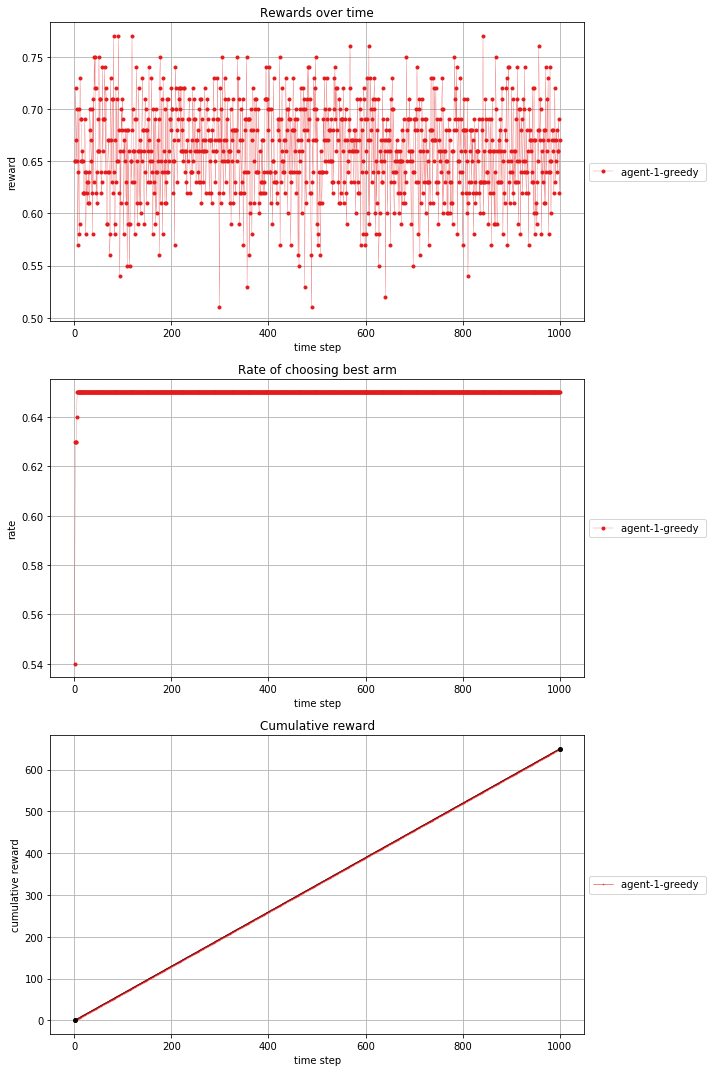

In [150]:
agent = Agent("averaging", "greedy")
agents = np.array([agent])
initp = np.array([0.4, 0.8]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initp)

### Epsilon-Greedy

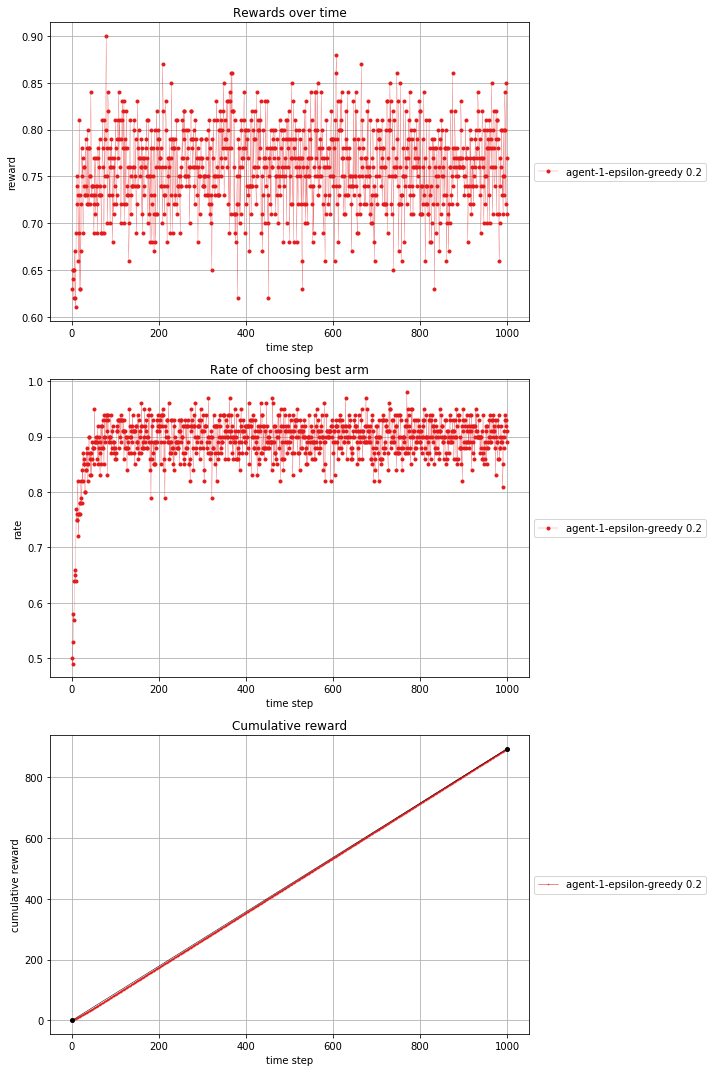

In [151]:
params = {"epsilon": 0.2}
agent = Agent("averaging", "epsilon-greedy", params)
agents = np.array([agent])
initp = np.array([0.4, 0.8]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initp, N=1000, repetitions=100)

### UCB

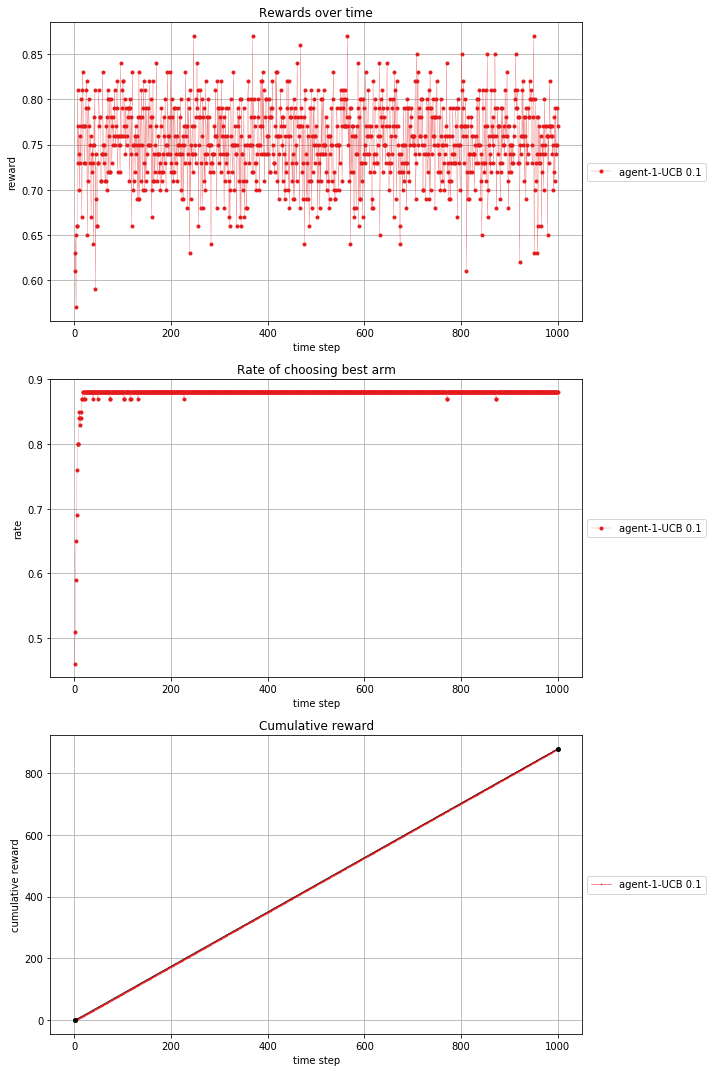

In [152]:
params = {"UCB_param": 0.1}
agent = Agent("averaging", "UCB", params)
agents = np.array([agent])
initp = np.array([0.4, 0.8]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initp)

### Gradient

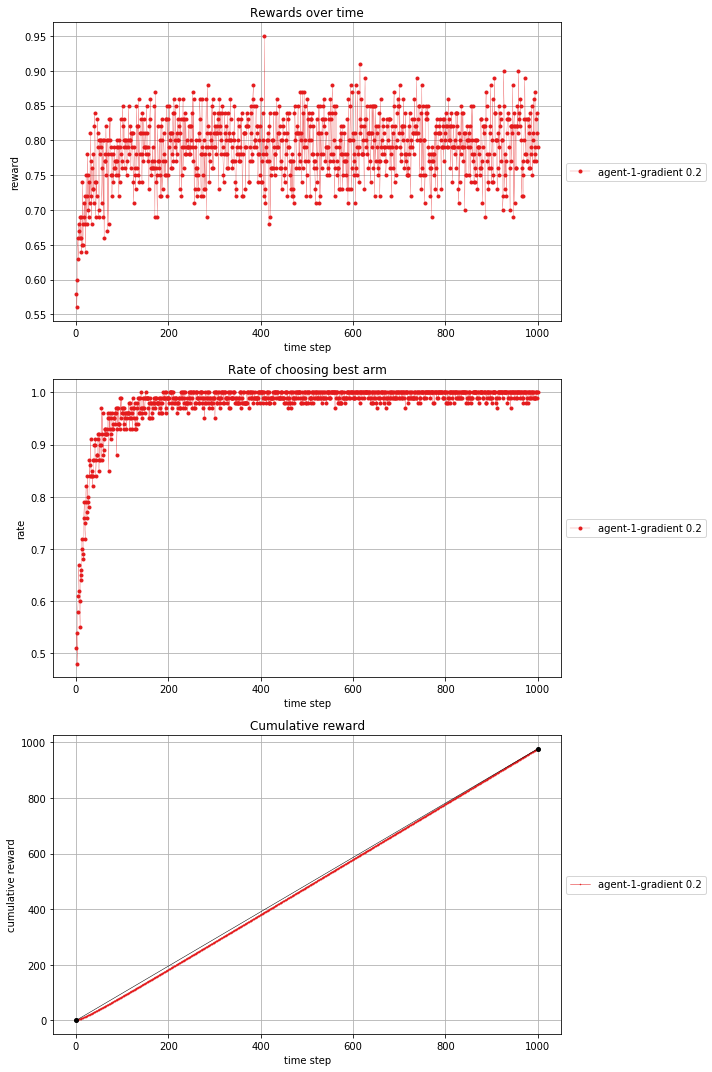

In [153]:
params = {"lr": 0.2}
agent = Agent("averaging", "gradient", params)
agents = np.array([agent])
initp = np.array([0.4, 0.8]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initp)

# 3. Bandits de 10 brazos

### Greedy

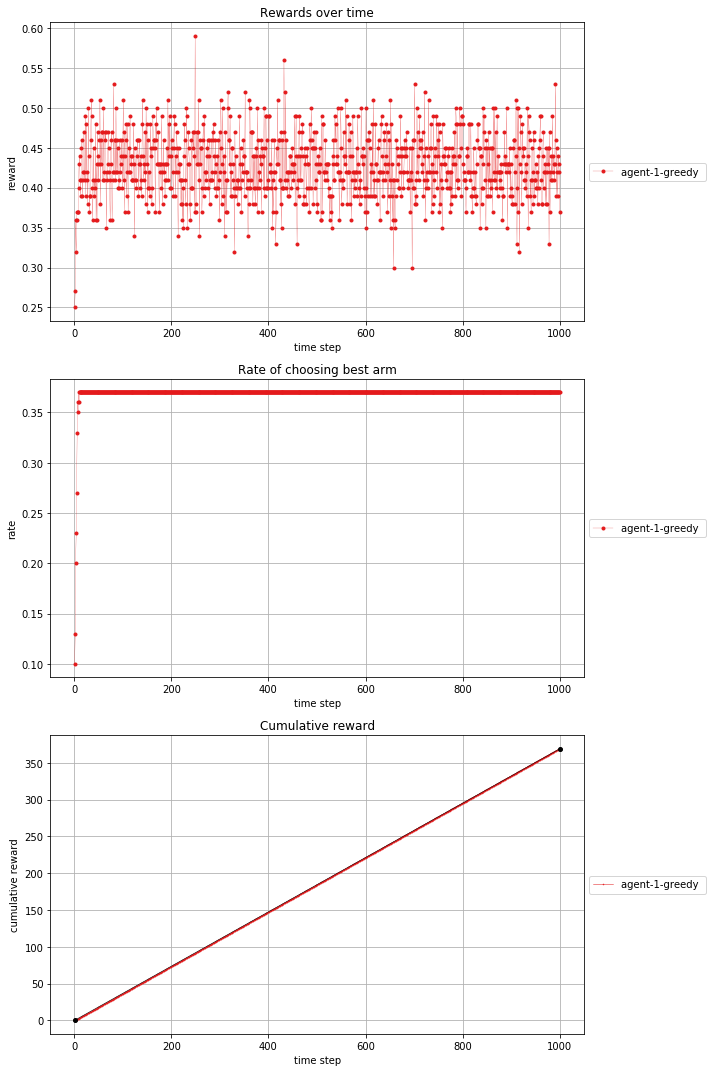

In [154]:
agent = Agent("averaging", "greedy")
agents = np.array([agent])
initp = np.array([0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initp)

### Epsilon-Greedy

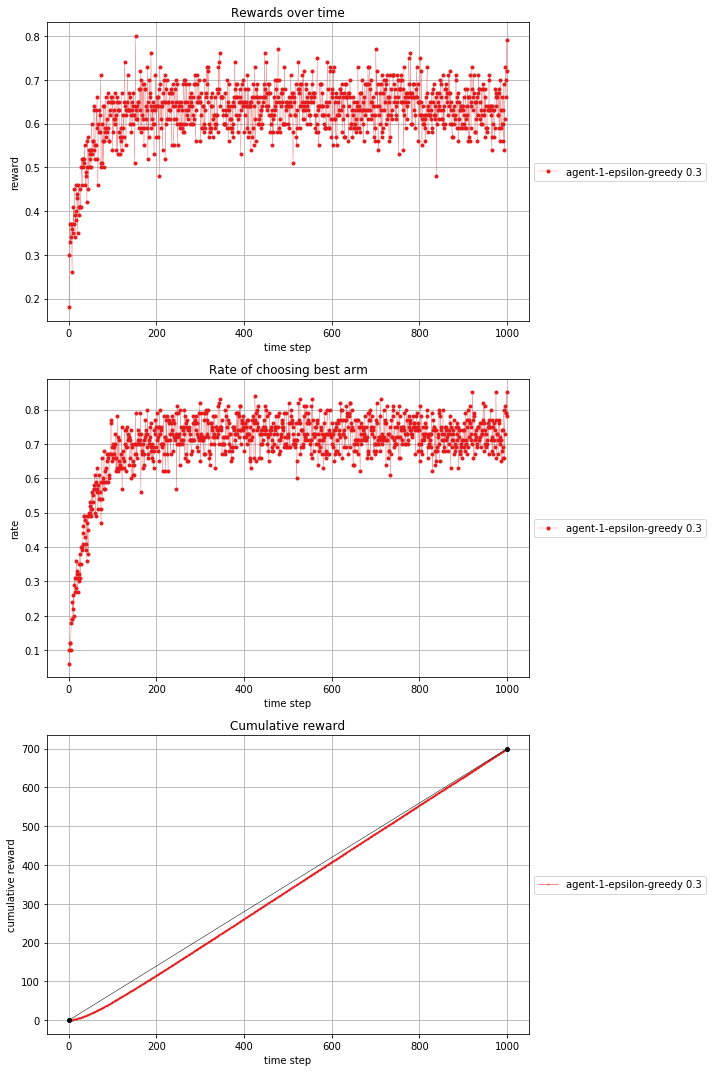

In [155]:
params = {"epsilon": 0.3}
agent = Agent("averaging", "epsilon-greedy", params)
agents = np.array([agent])
initp = np.array([0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initp)

### UCB

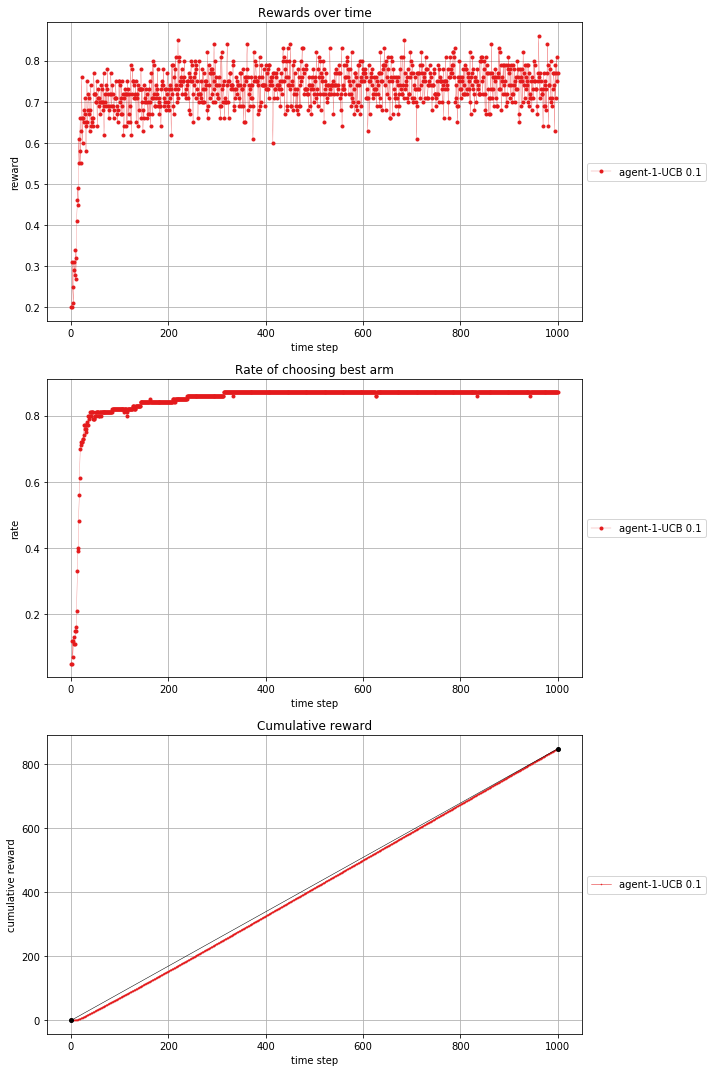

In [156]:
params = {"UCB_param": 0.1}
agent = Agent("averaging", "UCB", params)
agents = np.array([agent])
initp = np.array([0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initp)

### Gradient

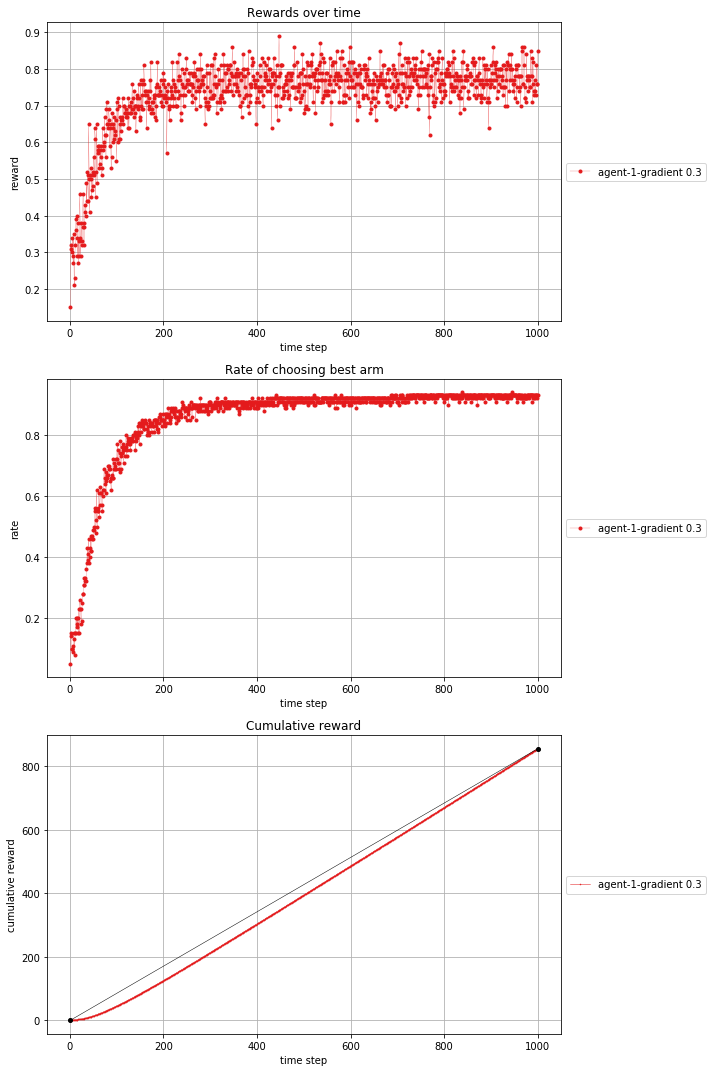

In [157]:
params = {"lr": 0.3}
agent = Agent("averaging", "gradient", params)
agents = np.array([agent])
initp = np.array([0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initp)

## Experimenting with several agent data on same plot

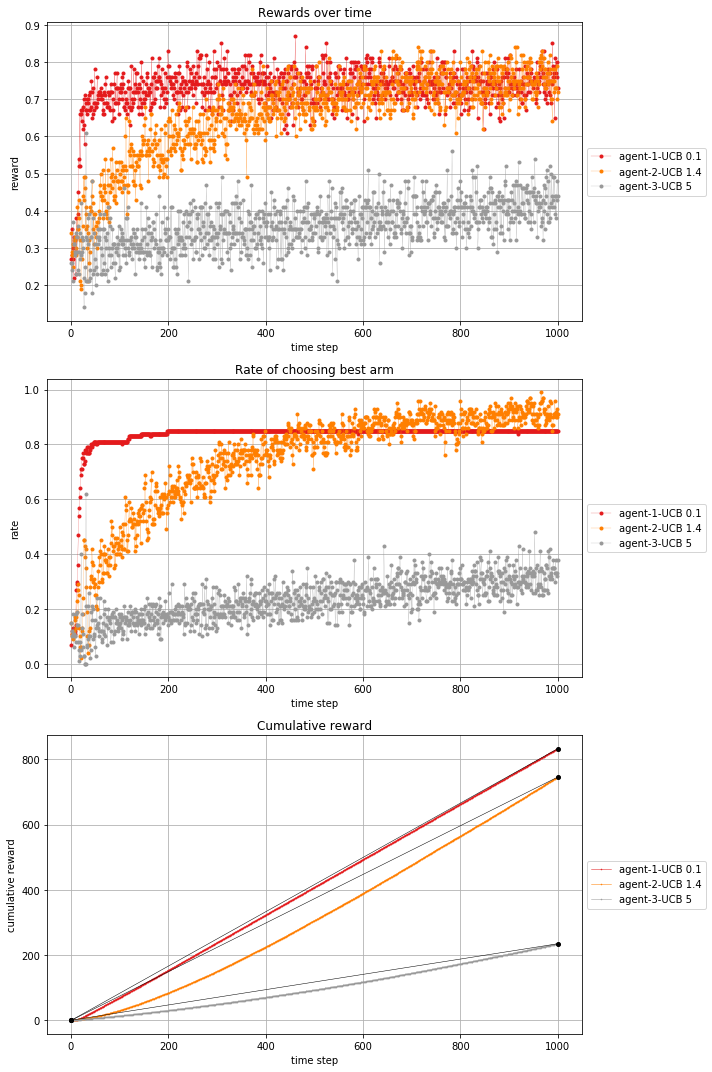

In [169]:
# UCB Experiment
params1 = {"UCB_param": 0.1}
agent1 = Agent("averaging", "UCB", params1)
params2 = {"UCB_param": 1.4}
agent2 = Agent("averaging", "UCB", params2)
params3 = {"UCB_param": 5}
agent3 = Agent("averaging", "UCB", params3)
#
agents = np.array([agent1, agent2, agent3])
initp = np.array([0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initp)

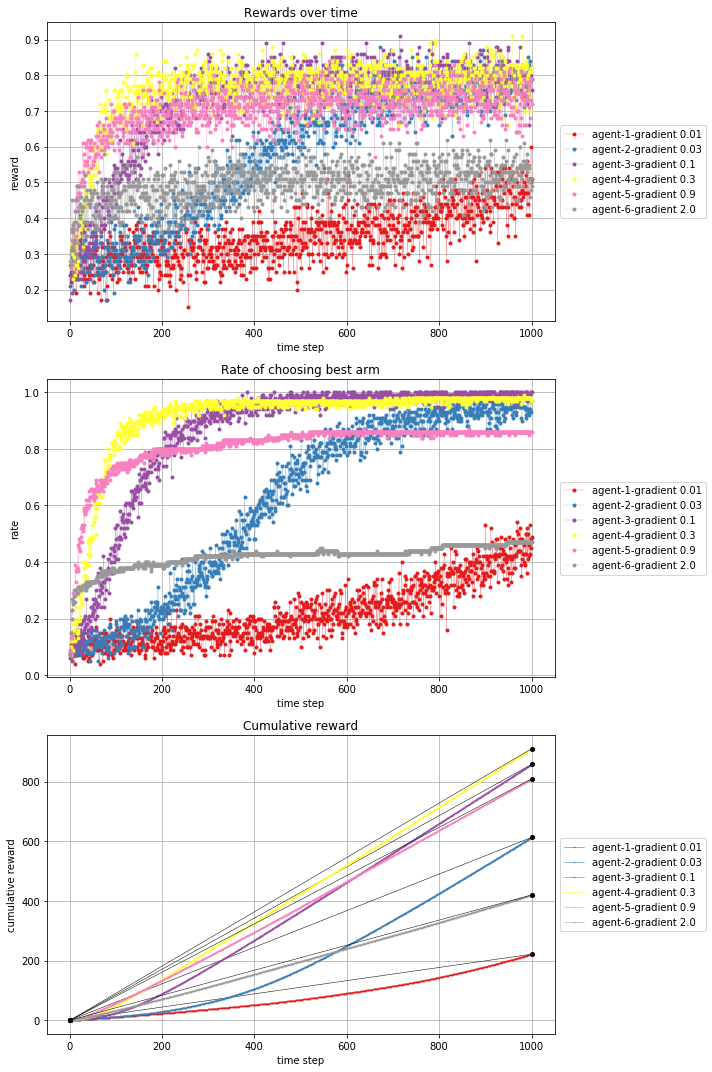

In [170]:
# Gradient Experiment
params1 = {"lr": 0.01}
agent1 = Agent("averaging", "gradient", params1)
params2 = {"lr": 0.03}
agent2 = Agent("averaging", "gradient", params2)
params3 = {"lr": 0.1}
agent3 = Agent("averaging", "gradient", params3)
params4 = {"lr": 0.3}
agent4 = Agent("averaging", "gradient", params4)
params5 = {"lr": 0.9}
agent5 = Agent("averaging", "gradient", params5)
params6 = {"lr": 2.0}
agent6 = Agent("averaging", "gradient", params6)
#
agents = np.array([agent1, agent2, agent3, agent4, agent5, agent6])
initp = np.array([0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initp)
#it [ H preferences ] [ softmax probs ]  sel.action last.action last.reward r_diff 

## Comparación entre algoritmos
Se buscaron "buenos" parámetros para cada algoritmo para que sea una comparación válida:

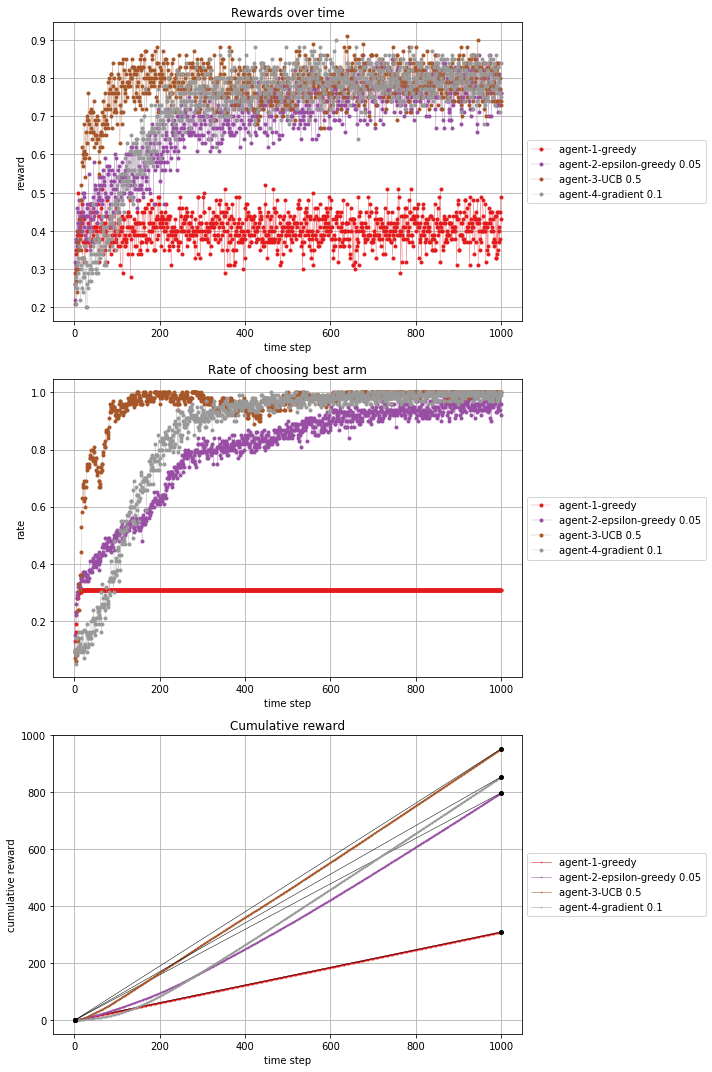

In [171]:
agent1 = Agent("averaging", "greedy")

params2 = {"epsilon": 0.05}
agent2 = Agent("averaging", "epsilon-greedy", params2)

params3 = {"UCB_param": 0.5}
agent3 = Agent("averaging", "UCB", params3)

params4 = {"lr": 0.1}
agent4 = Agent("averaging", "gradient", params4)

agents = np.array([agent1, agent2, agent3, agent4])
initp = np.array([0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initp, N=1000)

# 4. Estudio de Epsilon-Greedy
#### y la dependencia de epsilon en la regla de decisión

Se observa, como es esperado, que el parámetro epsilon influye directamente en la velocidad de convergencia del algoritmo (y hasta puede evitarla):

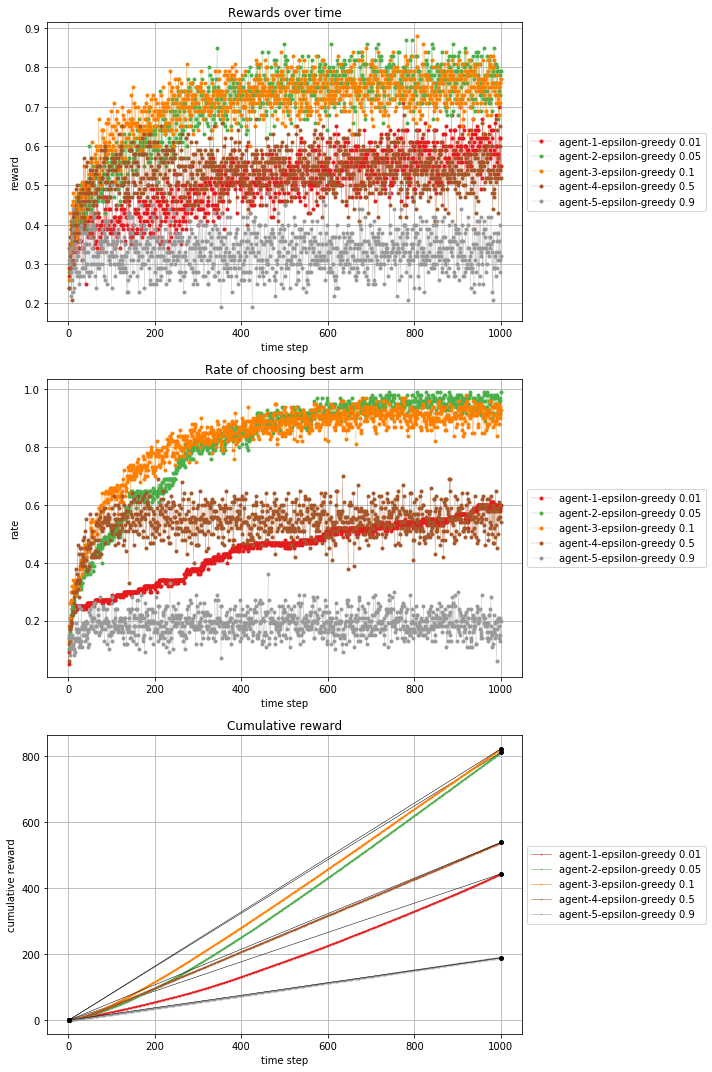

In [172]:
params1 = {"epsilon": 0.01}
agent1 = Agent("averaging", "epsilon-greedy", params1)
params2 = {"epsilon": 0.05}
agent2 = Agent("averaging", "epsilon-greedy", params2)
params3 = {"epsilon": 0.1}
agent3 = Agent("averaging", "epsilon-greedy", params3)
params4 = {"epsilon": 0.5}
agent4 = Agent("averaging", "epsilon-greedy", params4)
params5 = {"epsilon": 0.9}
agent5 = Agent("averaging", "epsilon-greedy", params5)
agents = np.array([agent1, agent2, agent3, agent4, agent5])
initp = np.array([0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initp)

### Epsilon alto

Un epsilon moderadamente alto (~0.5), produce un aprendizaje rápido de buenas estimaciones en las primeras iteraciones, pero puede estancar el aprendizaje en instancias más avanzadas.

Esto se debe a que a mayor epsilon, mayor exploración, lo que se traduce en un agente que actua de manera azarosa en una mayor cantidad de casos.

En el comienzo del episodio o aprendizaje, esto es muy positivo, ya que NO conocemos nada del environment, y nos permite estimar rápidamente las dinámicas de nuestro environment.

Pero a medida que el agente gana más conocimiento del environment, un epsilon grande se vuelve contraproducente, ya que evita seguir políticas óptimas (porque actuamos random) y no llegamos a actuar de una manera más greedy con respecto a nuestro estimativo.




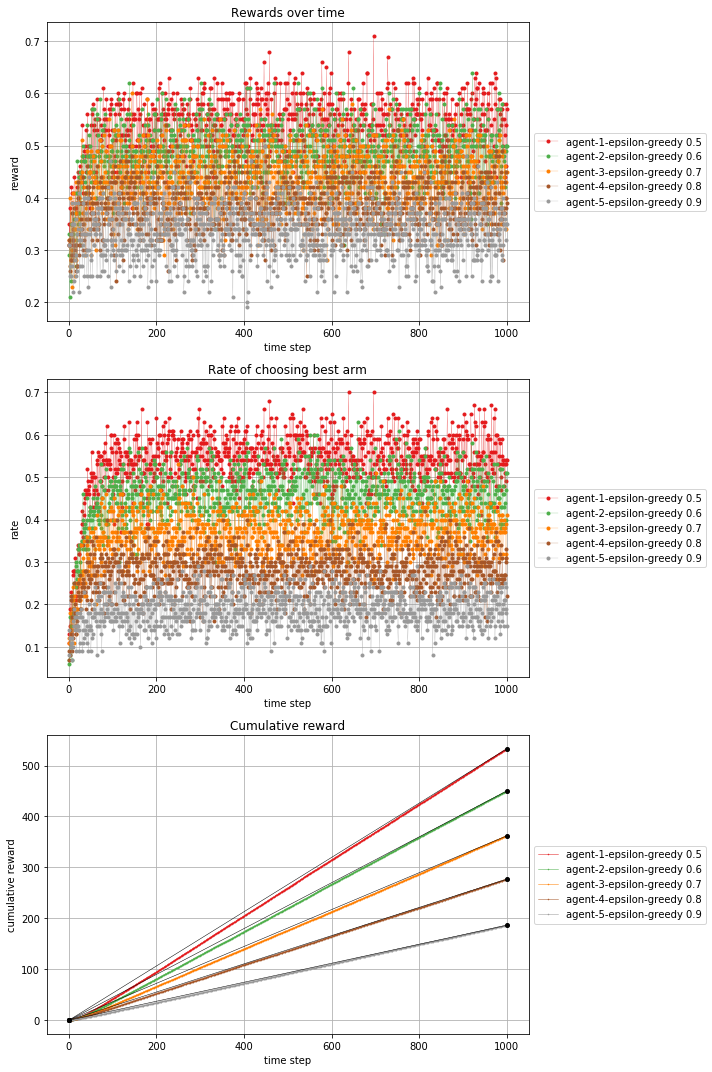

In [173]:
params1 = {"epsilon": 0.5}
agent1 = Agent("averaging", "epsilon-greedy", params1)
params2 = {"epsilon": 0.6}
agent2 = Agent("averaging", "epsilon-greedy", params2)
params3 = {"epsilon": 0.7}
agent3 = Agent("averaging", "epsilon-greedy", params3)
params4 = {"epsilon": 0.8}
agent4 = Agent("averaging", "epsilon-greedy", params4)
params5 = {"epsilon": 0.9}
agent5 = Agent("averaging", "epsilon-greedy", params5)
agents = np.array([agent1, agent2, agent3, agent4, agent5])
initp = np.array([0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initp)

### Epsilon bajo

Un epsilon muy pequeño (~0.01-0.05) vuelve al algoritmo lento en cuanto a velocidad de convergencia, pero en el límite, es el que nos dará mayor puntaje, ya que una vez conocido (o estimado con mucha certeza) el valor real de cada acción-estado, actuar greedy con respecto a eso es lo que nos dará mayor puntaje.

**Notar** que se usan **3.000 time steps**, y no 1.000 como en todos los plots anteriores:



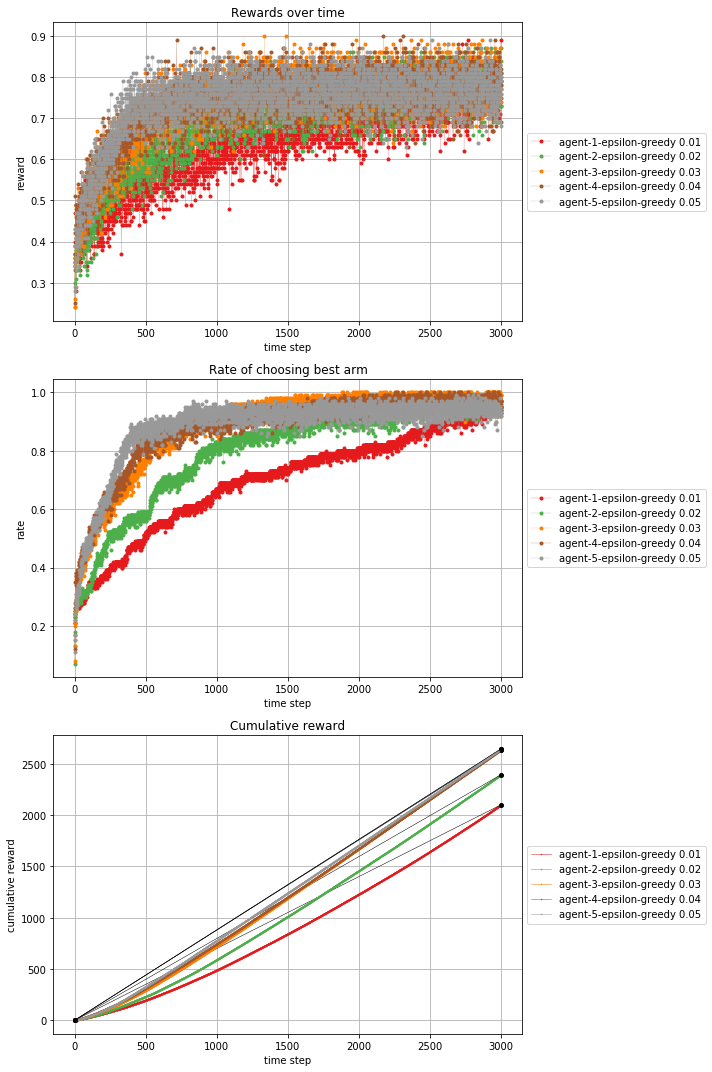

In [174]:
params1 = {"epsilon": 0.01}
agent1 = Agent("averaging", "epsilon-greedy", params1)
params2 = {"epsilon": 0.02}
agent2 = Agent("averaging", "epsilon-greedy", params2)
params3 = {"epsilon": 0.03}
agent3 = Agent("averaging", "epsilon-greedy", params3)
params4 = {"epsilon": 0.04}
agent4 = Agent("averaging", "epsilon-greedy", params4)
params5 = {"epsilon": 0.05}
agent5 = Agent("averaging", "epsilon-greedy", params5)
agents = np.array([agent1, agent2, agent3, agent4, agent5])
initp = np.array([0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initp, N=3000)

### Conclusión

Al comienzo del entrenamiento buscamos un epsilon alto para obtener rápidamente estimativos generales de las dinámicas de nuestro environment, pero a medida que ganamos mejores estimaciones, DEBEMOS reducir este epsilon acorde, para permitir la convergencia a un comportamiento óptimo.

En estos experimentos se usaron epsilon fijos, pero apuntan a que no existe un mejor o peor parámetro para cada problema a resolver, sino también para cada time-step dentro del problema.

Por eso es usual en la práctica comenzar con un epsilon razonable empíricamente, e ir reduciéndolo a medida que avanzamos en tiempo.

De esta forma obtendríamos lo mejor de ambos mundos.